# **Product Recognition of Food Products**

## Image Processing and Computer Vision - Assignment Module \#1


Contacts:

- Prof. Giuseppe Lisanti -> giuseppe.lisanti@unibo.it
- Prof. Samuele Salti -> samuele.salti@unibo.it
- Alex Costanzino -> alex.costanzino@unibo.it
- Francesco Ballerini -> francesco.ballerini4@unibo.it


Computer vision-based object detection techniques can be applied in super market settings to build a system that can identify products on store shelves.
An example of how this system could be used would be to assist visually impaired customers or automate common store management tasks like detecting low-stock or misplaced products, given an image of a shelf in a store.

## Task
Develop a computer vision system that, given a reference image for each product, is able to identify such product from one picture of a store shelf.

<figure>
<a href="https://imgbb.com/">
  <center>
  <img src="https://i.ibb.co/TwkMWnH/Screenshot-2024-04-04-at-14-54-51.png" alt="Screenshot-2024-04-04-at-14-54-51" border="0" width="300" />
</a>
</figure>

For each type of product displayed in the
shelf the system should report:
1. Number of instances;
1. Dimension of each instance (width and height in pixel of the bounding box that enclose them);
1. Position in the image reference system of each instance (center of the bounding box that enclose them).

#### Example of expected output
```
Product 0 - 2 instance found:
  Instance 1 {position: (256, 328), width: 57px, height: 80px}
  Instance 2 {position: (311, 328), width: 57px, height: 80px}
Product 1 – 1 instance found:
.
.
.
```

### Track A - Single Instance Detection
Develop an object detection system to identify single instance of products given one reference image for each item and a scene image.

The system should be able to correctly identify all the product in the shelves
image.

### Track B - Multiple Instances Detection
In addition to what achieved at step A, the system should also be able to detect multiple instances of the same product.

## Data
Two folders of images are provided:
* **Models**: contains one reference image for each product that the system should be able to identify.
* **Scenes**: contains different shelve pictures to test the developed algorithm in different scenarios. The images contained in this folder are corrupted by noise.

#### Track A - Single Instance Detection
* **Models**: {ref1.png to ref14.png}.
* **Scenes**: {scene1.png to scene5.png}.

#### Track B - Multiple Instances Detection
* **Models**: {ref15.png to ref27.png}.
* **Scenes**: {scene6.png to scene12.png}.

In [7]:
from google.colab import drive
import os
drive.mount('/content/drive')

!cp -r /content/drive/MyDrive/AssignmentsIPCV/dataset.zip ./
!unzip dataset.zip

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  dataset.zip
replace __MACOSX/._dataset? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## Evaluation criteria
1. **Procedural correctness**. There are several ways to solve the assignment. Design your own sound approach and justify every decision you make;

2. **Clarity and conciseness**. Present your work in a readable way: format your code and comment every important step;

3. **Correctness of results**. Try to solve as many instances as possible. You should be able to solve all the instances of the assignment, however, a thoroughly justified and sound procedure with a lower number of solved instances will be valued **more** than a poorly designed approach.

## Filtering

The scene images contain some noise. We therfore start by denoising the scene iamges using a bileteral filter.

In [9]:
import cv2
imgs_train = ['dataset/scenes/scene{}.png'.format(i) for i in range(1, 6)]
for scene in imgs_train:
  img = cv2.imread(scene)
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  denoised_img = cv2.bilateralFilter(img_rgb, 15, 200, 100)
  name = scene.replace(".png", "_filtered.png")
  cv2.imwrite(name, cv2.cvtColor(denoised_img, cv2.COLOR_RGB2BGR))
  print(f"save succeded as: {name}")

save succeded as: dataset/scenes/scene1_filtered.png
save succeded as: dataset/scenes/scene2_filtered.png
save succeded as: dataset/scenes/scene3_filtered.png
save succeded as: dataset/scenes/scene4_filtered.png
save succeded as: dataset/scenes/scene5_filtered.png


In [10]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

# Define a function for object detection pipeline
def object_retrieve(img_query, img_train_denoized, min_match_count):

    #Keypoint detection
    sift = cv2.xfeatures2d.SIFT_create()
    kp_query =  sift.detect(img_query)
    kp_train =  sift.detect(img_train_denoized)

    #Keypoint description
    kp_query, des_query =  sift.compute(img_query, kp_query)
    kp_train, des_train = sift.compute(img_train_denoized, kp_train)

    #Define parameters for the approximate nearest neighbor algorithm
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)

    # Initialize the Flann-based matcher
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des_query,des_train,k=2)
    good = []

    #filtering false matches, use 0.7 because SIFT
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)
    if len(good)> min_match_count:
      return good, kp_query, kp_train
    else:
      return None, kp_query, kp_train


In [11]:
def poistion_estimation(good,kp_query,kp_train, img_query, img_train_denoized):
  instances = []
  src_pts = np.float32([ kp_query[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
  dst_pts = np.float32([ kp_train[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

  # Find Homography matrix using RANSAC
  M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

  # Mask of discarded point used in visualization
  matchesMask = mask.ravel().tolist()

  # Get the bounding box corners of the query image
  h,w = img_query.shape
  pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)

  # Project the query corners onto the train image using the homography matrix
  train_corners = cv2.perspectiveTransform(pts,M)

  # Draw the bounding box
  img_train_with_box = cv2.polylines(img_train, [np.int32(train_corners)], True, (0, 255, 0), 3, cv2.LINE_AA)

  bounding_box_height = abs(train_corners[0][0][1] - train_corners[2][0][1])
  bounding_box_width = abs(train_corners[0][0][0] - train_corners[2][0][0])
  center_position = ((train_corners[0][0][0] + train_corners[2][0][0]) / 2, (train_corners[0][0][1] + train_corners[2][0][1]) / 2)

  return img_train_with_box, bounding_box_height, bounding_box_width, center_position

Product dataset/models/ref1.png in dataset/scenes/scene1_filtered.png:True
Product dataset/models/ref2.png in dataset/scenes/scene1_filtered.png:True
Product dataset/models/ref3.png in dataset/scenes/scene1_filtered.png:False
Product dataset/models/ref4.png in dataset/scenes/scene1_filtered.png:False
Product dataset/models/ref5.png in dataset/scenes/scene1_filtered.png:False
Product dataset/models/ref6.png in dataset/scenes/scene1_filtered.png:False
Product dataset/models/ref7.png in dataset/scenes/scene1_filtered.png:False
Product dataset/models/ref8.png in dataset/scenes/scene1_filtered.png:False
Product dataset/models/ref9.png in dataset/scenes/scene1_filtered.png:False
Product dataset/models/ref10.png in dataset/scenes/scene1_filtered.png:False
Product dataset/models/ref11.png in dataset/scenes/scene1_filtered.png:False
Product dataset/models/ref12.png in dataset/scenes/scene1_filtered.png:False
Product dataset/models/ref13.png in dataset/scenes/scene1_filtered.png:False
Product da

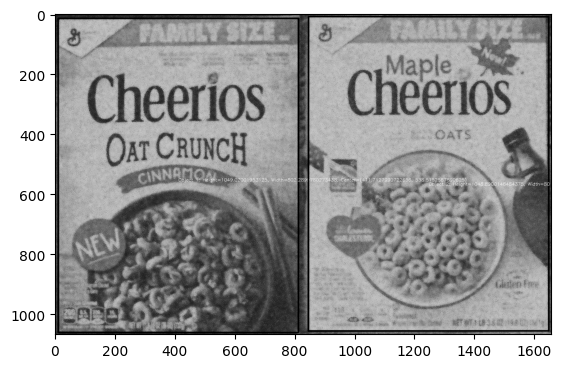

Object 1: 1 instance found, Height=1049.02001953125, Width=802.2899780273438, Center=(411.7127990722656, 538.5152587890625)
Object 2: 1 instance found, Height=1048.8900146484375, Width=801.97998046875, Center=(1247.331787109375, 532.9126586914062)
Product dataset/models/ref1.png in dataset/scenes/scene2_filtered.png:False
Product dataset/models/ref2.png in dataset/scenes/scene2_filtered.png:False
Product dataset/models/ref3.png in dataset/scenes/scene2_filtered.png:True
Product dataset/models/ref4.png in dataset/scenes/scene2_filtered.png:True
Product dataset/models/ref5.png in dataset/scenes/scene2_filtered.png:True
Product dataset/models/ref6.png in dataset/scenes/scene2_filtered.png:False
Product dataset/models/ref7.png in dataset/scenes/scene2_filtered.png:False
Product dataset/models/ref8.png in dataset/scenes/scene2_filtered.png:False
Product dataset/models/ref9.png in dataset/scenes/scene2_filtered.png:False
Product dataset/models/ref10.png in dataset/scenes/scene2_filtered.png:

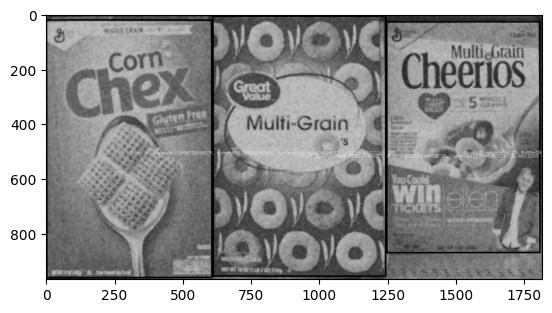

Object 3: 1 instance found, Height=941.0999755859375, Width=605.260009765625, Center=(304.5604248046875, 492.26080322265625)
Object 4: 1 instance found, Height=948.8900146484375, Width=632.3800048828125, Center=(927.2745361328125, 483.02001953125)
Object 5: 1 instance found, Height=842.25, Width=560.5599975585938, Center=(1528.166748046875, 450.0919189453125)
Product dataset/models/ref1.png in dataset/scenes/scene3_filtered.png:False
Product dataset/models/ref2.png in dataset/scenes/scene3_filtered.png:False
Product dataset/models/ref3.png in dataset/scenes/scene3_filtered.png:False
Product dataset/models/ref4.png in dataset/scenes/scene3_filtered.png:False
Product dataset/models/ref5.png in dataset/scenes/scene3_filtered.png:False
Product dataset/models/ref6.png in dataset/scenes/scene3_filtered.png:False
Product dataset/models/ref7.png in dataset/scenes/scene3_filtered.png:False
Product dataset/models/ref8.png in dataset/scenes/scene3_filtered.png:True
Product dataset/models/ref9.png

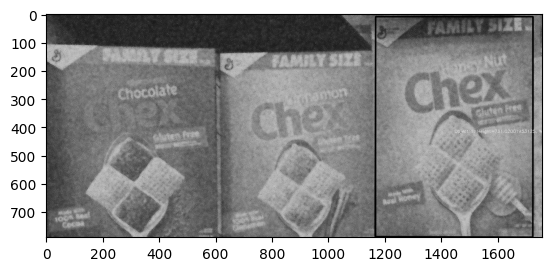

Object 8: 1 instance found, Height=781.02001953125, Width=556.9500122070312, Center=(1447.1370849609375, 400.1015319824219)
Product dataset/models/ref1.png in dataset/scenes/scene4_filtered.png:True
Product dataset/models/ref2.png in dataset/scenes/scene4_filtered.png:False
Product dataset/models/ref3.png in dataset/scenes/scene4_filtered.png:False
Product dataset/models/ref4.png in dataset/scenes/scene4_filtered.png:False
Product dataset/models/ref5.png in dataset/scenes/scene4_filtered.png:False
Product dataset/models/ref6.png in dataset/scenes/scene4_filtered.png:False
Product dataset/models/ref7.png in dataset/scenes/scene4_filtered.png:False
Product dataset/models/ref8.png in dataset/scenes/scene4_filtered.png:False
Product dataset/models/ref9.png in dataset/scenes/scene4_filtered.png:False
Product dataset/models/ref10.png in dataset/scenes/scene4_filtered.png:False
Product dataset/models/ref11.png in dataset/scenes/scene4_filtered.png:False
Product dataset/models/ref12.png in dat

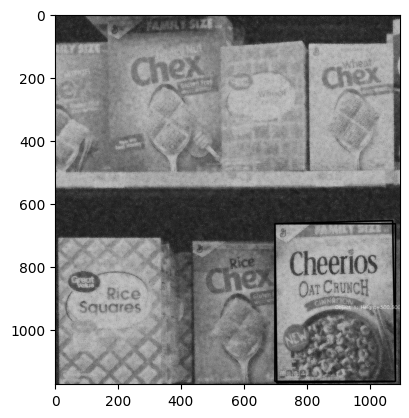

Object 1: 1 instance found, Height=500.6000061035156, Width=381.8500061035156, Center=(887.8916015625, 915.5926513671875)
Product dataset/models/ref1.png in dataset/scenes/scene5_filtered.png:False
Product dataset/models/ref2.png in dataset/scenes/scene5_filtered.png:False
Product dataset/models/ref3.png in dataset/scenes/scene5_filtered.png:False
Product dataset/models/ref4.png in dataset/scenes/scene5_filtered.png:False
Product dataset/models/ref5.png in dataset/scenes/scene5_filtered.png:False
Product dataset/models/ref6.png in dataset/scenes/scene5_filtered.png:False
Product dataset/models/ref7.png in dataset/scenes/scene5_filtered.png:False
Product dataset/models/ref8.png in dataset/scenes/scene5_filtered.png:False
Product dataset/models/ref9.png in dataset/scenes/scene5_filtered.png:False
Product dataset/models/ref10.png in dataset/scenes/scene5_filtered.png:False
Product dataset/models/ref11.png in dataset/scenes/scene5_filtered.png:True
Product dataset/models/ref12.png in datas

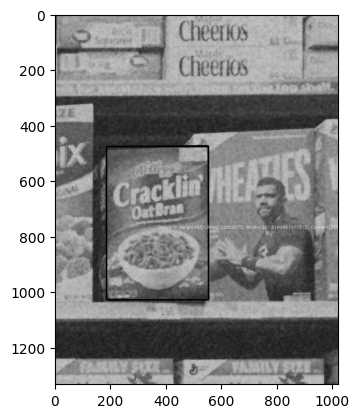

Object 11: 1 instance found, Height=551.8499755859375, Width=367.6199951171875, Center=(368.9410705566406, 752.9805297851562)


In [12]:
contain_img = {}
# Iterate among scenes
imgs_train_filterd = ['dataset/scenes/scene{}_filtered.png'.format(i) for i in range(1, 6)]
for scene_image in imgs_train_filterd:
  # Count instances of each object
  object_counts = {}
  # Initialize variables to store accumulated bounding box information
  all_bounding_boxes = []
  all_center_positions = []
  img_train = cv2.imread(scene_image,0)
  #Iterate among queryimage to see if in scene
  for i in range(1, 15):
      img_query = cv2.imread('dataset/models/ref{}.png'.format(i),0)

      found, kp_query, kp_train = object_retrieve(img_query, img_train, 80)

      print("Product {} in {}:{}".format('dataset/models/ref{}.png'.format(i),scene_image,found != None))

      if found != None:
        img_train_with_box, bounding_box_height, bounding_box_width, center_position = poistion_estimation(found, kp_query, kp_train, img_query, img_train)
        all_bounding_boxes.append((bounding_box_height, bounding_box_width,i))
        all_center_positions.append(center_position)

        # Count instances of each object
        object_counts.setdefault(len(all_bounding_boxes), 0)
        object_counts[len(all_bounding_boxes)] += 1
    # Draw all bounding boxes on a single image
  if img_train_with_box is not None:
      img_with_boxes = img_train.copy()
      for i, ((bounding_box_height, bounding_box_width, number), center_position) in enumerate(zip(all_bounding_boxes, all_center_positions), 1):
          cv2.rectangle(img_with_boxes, (int(center_position[0] - bounding_box_width / 2),
                                           int(center_position[1] - bounding_box_height / 2)),
                          (int(center_position[0] + bounding_box_width / 2),
                           int(center_position[1] + bounding_box_height / 2)), (0, 0, 255), 3)
          text = f'Object {i}: Height={round(bounding_box_height, 2)}, Width={round(bounding_box_width, 2)}, Center={center_position}'
          cv2.putText(img_with_boxes, text, (int(center_position[0]), int(center_position[1] + 20 * i)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

      plt.imshow(cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB))
      plt.show()
      for k, ((bounding_box_height, bounding_box_width, number), center_position) in enumerate(zip(all_bounding_boxes, all_center_positions), 1):
        count_text = f"{object_counts[k]} instance{'s' if object_counts[k] > 1 else ''} found"
        print(f'Object {number}: {count_text}, Height={round(bounding_box_height, 2)}, Width={round(bounding_box_width, 2)}, Center={center_position}')



# *For* mutiple

In [15]:
import cv2
imgs_train = ['dataset/scenes/scene{}.png'.format(i) for i in range(6, 13)]
for scene in imgs_train:
  img = cv2.imread(scene)
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  denoised_img = cv2.bilateralFilter(img_rgb, 15, 200, 100)
  name = scene.replace(".png", "_filtered.png")
  cv2.imwrite(name, cv2.cvtColor(denoised_img, cv2.COLOR_RGB2BGR))
  print(f"save succeded as: {name}")

save succeded as: dataset/scenes/scene6_filtered.png
save succeded as: dataset/scenes/scene7_filtered.png
save succeded as: dataset/scenes/scene8_filtered.png
save succeded as: dataset/scenes/scene9_filtered.png
save succeded as: dataset/scenes/scene10_filtered.png
save succeded as: dataset/scenes/scene11_filtered.png
save succeded as: dataset/scenes/scene12_filtered.png


In [30]:
def detect_multiple(img_query, scene_image, treshold):
      # save the image dimensions
      W, H = img_query.shape[:2]
      # Define the new dimensions to make query image smaller than scene_image
      new_width = W-500  # New width in pixels
      new_height = H-500  # New height in pixels

      # Convert data type if necessary
      if img_query.dtype != img_train.dtype:
        img_query = img_query.astype(img_train.dtype)

      # Resize the image
      resized_img = cv2.resize(img, (new_width, new_height))

      match = cv2.matchTemplate(image=scene_image, templ=resized_img,method=cv2.TM_CCOEFF_NORMED)
      # Select rectangles with
      # confidence greater than threshold
      (y_points, x_points) = np.where(match >= treshold)

      # initialize our list of rectangles
      boxes = list()

      # loop over the starting (x, y)-coordinates again
      for (x, y) in zip(x_points, y_points):

          # update our list of rectangles
          boxes.append((x, y, x + W, y + H))


      # loop over the final bounding boxes
      for (x1, y1, x2, y2) in boxes:

          # draw the bounding box on the image
          cv2.rectangle(img, (x1, y1), (x2, y2),
                        (255, 0, 0), 3)

      # Show the template and the final output
      cv2.imshow("Template", img_query)
      cv2.imshow("After NMS", img)
      cv2.waitKey(0)

      # destroy all the windows
      # manually to be on the safe side
      cv2.destroyAllWindows()

In [31]:
contain_img = {}
# Iterate among scenes
imgs_train_filterd = ['dataset/scenes/scene{}_filtered.png'.format(i) for i in range(6, 13)]
for scene_image in imgs_train_filterd:
    img_train = cv2.imread(scene_image,0)
    for i in range(1, 15):
      img_query = cv2.imread('dataset/models/ref{}.png'.format(i),0)
      detect_multiple(img_query, img_train, 0.4)

error: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/templmatch.cpp:1164: error: (-215:Assertion failed) (depth == CV_8U || depth == CV_32F) && type == _templ.type() && _img.dims() <= 2 in function 'matchTemplate'


We do not detect everything in scene 3, scene 4 and  scene 5 (the more blurry ones)

In [ ]:
#Add diffusion step (denosing)